# RLHF Fine-Tuning for Degradation Transformer

This notebook demonstrates how to fine-tune the pre-trained Degradation Transformer using Reinforcement Learning (REINFORCE) to improve long-term trajectory prediction.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
from torch.utils.data import DataLoader

## 1. Load Pre-trained Model
We load the model weights and configuration from the saved files.

In [2]:
import json
from safetensors.torch import load_model

# Load Config
with open('degradation_transformer_model_config.json', 'r') as f:
    config = json.load(f)

# Initialize Model Structure
model = DegradationTransformer(
    vocab_size=config['vocab_size'],
    context_window=config['context_window'],
    embedding_dim=config['embedding_dim'],
    num_heads=config['num_heads'],
    num_blocks=config['num_blocks']
)

# Load Weights
load_model(model, 'degradation_transformer_model.safetensors')
print("Model loaded successfully!")

Model loaded successfully!


In [16]:
print(f"Pos embed shape: {model.tpembed.pos_embed.weight.shape}")

# Create dummy input
x = torch.randint(0, config['vocab_size'], (32, 40))
print(f"Input shape: {x.shape}")

# Run forward
out = model.tpembed.token_embed(x)
print("Forward pass successful!")
assert out.shape == (32, 40, config['embedding_dim'])

Pos embed shape: torch.Size([40, 64])
Input shape: torch.Size([32, 40])
Forward pass successful!


## 2. Generate Data for RLHF
We generate a fresh batch of degradation episodes. We need long episodes to have enough future steps for the reward calculation.

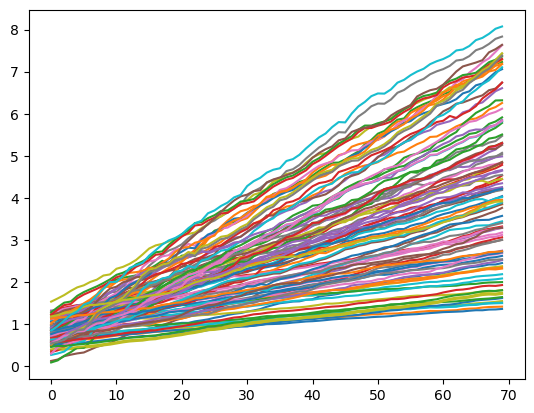

In [3]:
# Parameters
CONTEXT_WINDOW = config['context_window']
FUTURE_WINDOW = 20  # Length of trajectory to predict and reward
EPISODE_LENGTH = CONTEXT_WINDOW + FUTURE_WINDOW + 10 # Extra buffer
NUM_EPISODES = 60

# Generate Data (Paris Law)
lin_episodes = np.empty((0, EPISODE_LENGTH))
for c in np.linspace(0.01, 0.1, 50):
    
    lin = LinearDegradation(length=EPISODE_LENGTH, dim=1, c=c, mu_e=0, sigma_e=c/2)
    episodes_i = lin.generate_episode(x0=np.abs(np.random.randn(NUM_EPISODES)*0.3+0.7))  # Initial crack lengths in meters
    lin_episodes = np.concatenate([lin_episodes, episodes_i], axis=0)

#drop invalid values
lin_episodes = lin_episodes[~np.isnan(lin_episodes).any(axis=1)]
lin_episodes = lin_episodes[(lin_episodes<15).all(axis=1)]
lin_episodes = lin_episodes[(lin_episodes>=0).all(axis=1)]

# plot 20 random episodes
plt.plot(lin_episodes[np.random.randint(0, lin_episodes.shape[0], size=100)].T)
lin_episodes.min(), lin_episodes.max(), lin_episodes.shape


data = lin_episodes

#

## 3. Prepare RL Dataset and Learner
We use the new `RLDataset` and `RLHFLearner`.

In [4]:
# Create Dataset
rl_dataset = RLDataset(data, CONTEXT_WINDOW, FUTURE_WINDOW, config['vocab_size'])
train_loader = DataLoader(rl_dataset, batch_size=32, shuffle=True)

# Initialize Learner
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) # Low learning rate for fine-tuning
reward_func = MSE_Reward()

learner = RLHFLearner(
    model=model,
    optim=optimizer,
    reward_func=reward_func,
    train_loader=train_loader,
    cbs=[], # Add callbacks if needed
    device='cpu' # or 'cuda'/'mps'
)

## 4. Run RLHF Training
We run the `fit_rl` method. We use a temperature > 0 to encourage exploration during training.

In [5]:
print("Starting RLHF Fine-tuning...")
learner.fit_rl(
    num_epochs=5,
    future_window=FUTURE_WINDOW,
    temperature=1.0, # Exploration
    baseline_momentum=0.9
)

Starting RLHF Fine-tuning...


DEBUG: vocab_size=1000
DEBUG: curr_window_float shape=torch.Size([32, 40])
DEBUG: max token=768
DEBUG: min token=0


IndexError: index out of range in self

## 5. Evaluate Results
Let's compare the model's predictions after fine-tuning.

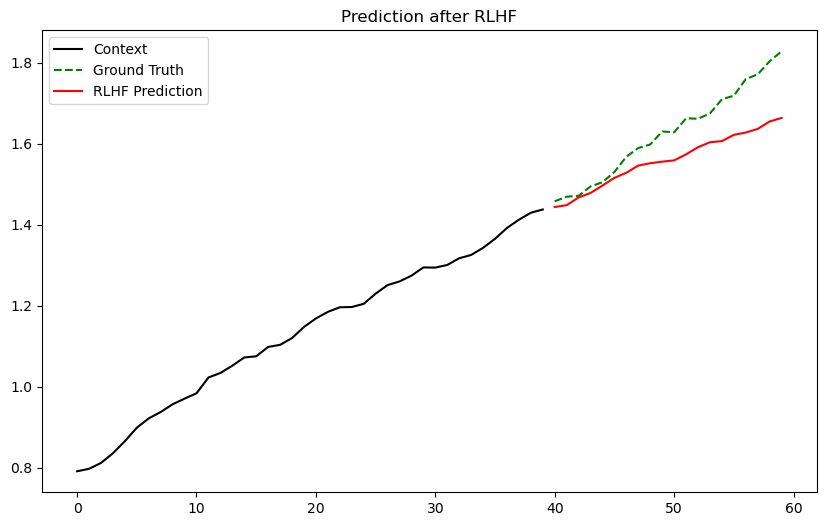

In [ ]:
# Pick a random test sample
test_idx = np.random.randint(0, lin_episodes.shape[0], size=1)
x_context = data[test_idx, :CONTEXT_WINDOW]
y_true = data[test_idx, CONTEXT_WINDOW:CONTEXT_WINDOW+FUTURE_WINDOW]

# Predict
prediction = learner.predict(x_context, num_periods=FUTURE_WINDOW, temperature=0.0) # Greedy for eval
y_pred = prediction[:, CONTEXT_WINDOW:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(CONTEXT_WINDOW), x_context.T, 'k-', label='Context')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_true.T, 'g--', label='Ground Truth')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_pred.T, 'r-', label='RLHF Prediction')
plt.legend()
plt.title("Prediction after RLHF")
plt.show()